<a href="https://colab.research.google.com/github/davidfague/single-cell-tuning/blob/main/tuning_SST_PV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/davidfague/single-cell-tuning.git

Cloning into 'single-cell-tuning'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 107 (delta 52), reused 21 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (107/107), 459.36 KiB | 5.22 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [2]:
!pip install --upgrade pip
!pip install --quiet allensdk neuron

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.1/973.1 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [3]:
from allensdk.api.queries.biophysical_api import BiophysicalApi
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils
import sys

import matplotlib.pyplot as plt

In [4]:
bp = BiophysicalApi()

# PV is from: https://celltypes.brain-map.org/experiment/electrophysiology/484635029
# SST is from: https://celltypes.brain-map.org/experiment/electrophysiology/476686112

cell_to_use = 'SST'

if cell_to_use == 'SST':
    query = bp.get_neuronal_models(476686112)
    id_to_use = query[0]['id']
elif cell_to_use =='PV':
    query = bp.get_neuronal_models(484635029)
    id_to_use = query[0]['id']

print(query)

[{'id': 477878284, 'name': 'Biophysical - perisomatic_Sst-IRES-Cre;Ai14-188740.03.02.01', 'neuron_reconstruction_id': 491119369, 'neuronal_model_template_id': 329230710, 'specimen_id': 476686112}, {'id': 497232660, 'name': 'Biophysical - all active_Sst-IRES-Cre;Ai14-188740.03.02.01', 'neuron_reconstruction_id': 491119369, 'neuronal_model_template_id': 491455321, 'specimen_id': 476686112}]


In [5]:
bp.cache_stimulus = False # Change to False to not download the large stimulus NWB file
bp.cache_data(id_to_use) # 'id'

2025-02-21 20:31:33,189 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657210401
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657210401
2025-02-21 20:31:36,773 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657210404
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657210404
2025-02-21 20:31:36,992 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/395337293
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/395337293
2025-02-21 20:31:37,156 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_fi

In [6]:
# Compile the modfiles
!nrnivmodl modfiles

# Create the h object
description = Config().load('manifest.json')
utils = Utils(description)

# convert 'values' from string to float
for dict in utils.description.data['genome']:
  for key,item in dict.items():
    if key == 'value':
      dict[key] = float(item)

h = utils.h

/usr/local/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/content
Mod files: "modfiles/modfiles/CaDynamics.mod" "modfiles/modfiles/Ca_HVA.mod" "modfiles/modfiles/Ca_LVA.mod" "modfiles/modfiles/Ih.mod" "modfiles/modfiles/Im.mod" "modfiles/modfiles/Im_v2.mod" "modfiles/modfiles/Kd.mod" "modfiles/modfiles/K_P.mod" "modfiles/modfiles/K_T.mod" "modfiles/modfiles/Kv2like.mod" "modfiles/modfiles/Kv3_1.mod" "modfiles/modfiles/Nap.mod" "modfiles/modfiles/NaTa.mod" "modfiles/modfiles/NaTs.mod" "modfiles/modfiles/NaV.mod" "modfiles/modfiles/SK.mod"

Creating 'x86_64' directory for .o files.

 -> NMODL ../modfiles/CaDynamics.mod
 -> NMODL ../modfiles/Ca_HVA.mod
 -> NMODL ../modfiles/Ca_LVA.mod
 -> Compiling mod_func.cpp
Translating CaDynamics.mod into /content/x86_64/CaDynamics.c
Thread Safe
 -> NMODL ../modfiles/Ih.mod
Translating Ca_HVA.mod into /content/x86_64/Ca_HV

In [7]:
# Configure morphology
manifest = description.manifest
morphology_path = description.manifest.get_path('MORPHOLOGY')
utils.generate_morphology(morphology_path.encode('ascii', 'ignore'))

warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768


In [8]:
 # defaults if missing from allen cell and also for tuning
 # could split
user_specifications = {
    "R-in": 100, # MOhms
    "cm": [
        {
          "section": "soma",
          "cm": 1
        },
        {
          "section": "axon",
          "cm": 1
        },
        {
          "section": "dend",
          "cm": 1
        },
        {
          "section": "apic",
          "cm": 1
        }
      ],
    "e_pas": -65.75
}

In [9]:
# update missing properties to user_specifications if they're not already in the allen specifications
if "e_pas" not in utils.description.data["passive"][0].keys():
  utils.description.data["passive"][0]["e_pas"] = user_specifications["e_pas"]

if "cm" not in utils.description.data["passive"][0].keys():
  utils.description.data["passive"][0]["cm"] = user_specifications["cm"]

if "ra" not in utils.description.data["passive"][0].keys():
  utils.description.data["passive"][0]["ra"] = user_specifications["ra"]

In [10]:
utils.description.data["passive"] # display

[{'ra': 153.714713714,
  'cm': [{'section': 'soma', 'cm': 0.55447777707},
   {'section': 'axon', 'cm': 0.55447777707},
   {'section': 'dend', 'cm': 0.55447777707}],
  'e_pas': -79.65586853027344}]

In [11]:
# build the cell. Its parts will be assigned to the h object
utils.load_cell_parameters()

In [12]:
sys.path.append('single-cell-tuning/')
from download_from_allen_and_tune_r_in import update_sections
from Simulation import RInSimulation

In [33]:
utils.description.data['genome']

[{'section': 'soma',
  'name': 'gbar_Ih',
  'value': 0.0017877435830761807,
  'mechanism': 'Ih'},
 {'section': 'soma',
  'name': 'gbar_NaV',
  'value': 0.05118910631895057,
  'mechanism': 'NaV'},
 {'section': 'soma',
  'name': 'gbar_Kd',
  'value': 8.903838040127954e-11,
  'mechanism': 'Kd'},
 {'section': 'soma',
  'name': 'gbar_Kv2like',
  'value': 0.0002725790772869774,
  'mechanism': 'Kv2like'},
 {'section': 'soma',
  'name': 'gbar_Kv3_1',
  'value': 0.10521580755926842,
  'mechanism': 'Kv3_1'},
 {'section': 'soma',
  'name': 'gbar_K_T',
  'value': 0.007838697435023162,
  'mechanism': 'K_T'},
 {'section': 'soma',
  'name': 'gbar_Im_v2',
  'value': 2.8103810231817594e-07,
  'mechanism': 'Im_v2'},
 {'section': 'soma',
  'name': 'gbar_SK',
  'value': 3.095338402020649e-08,
  'mechanism': 'SK'},
 {'section': 'soma',
  'name': 'gbar_Ca_HVA',
  'value': 0.0008814678006675907,
  'mechanism': 'Ca_HVA'},
 {'section': 'soma',
  'name': 'gbar_Ca_LVA',
  'value': 0.002604826842658681,
  'mechan

In [13]:
update_sections(
    data = utils.description.data['genome'],
    )

utils.load_cell_parameters()

TypeError: string indices must be integers, not 'str'

In [39]:
list(h.dend[0])

for seg in h.dend[0]:
    print(seg)

dend[0](0.5)


In [14]:
target_metric = {
    'SST': {
        'R-in': 100,
        'RMP': {
            'mean': -65.75,
            'std': 3.76
            }
    },
    'PV': {
        'R-in': 100,
        # 'RMP': {
        #     'mean': -65.75,
        #     'std':
        # }
    }
}

In [30]:
target_metric['PV']['RMP'] = {}#(1, 0.05)
target_metric['PV']['RMP']['mean'] = 1
target_metric['PV']['RMP']['std'] = 0.5

In [31]:
target_metric['PV']

{'R-in': 100, 'RMP': {'mean': 1, 'std': 0.5}, 'RMP_mean': 1}

In [ ]:
RInSimulation(h)

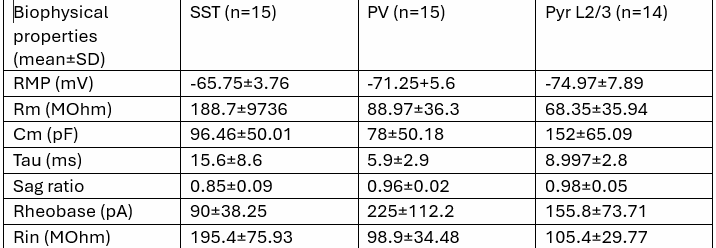

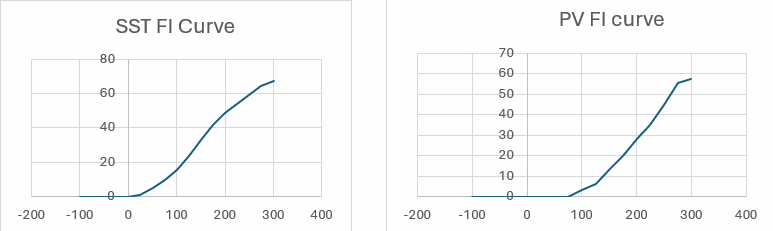

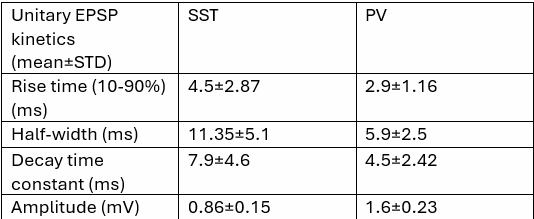